In [1]:
# Brain Tumor Recognition

# Vorgehen
1. Data preprocessing
2. Convulutional NN aufbauen
3. CNN trainieren
4. Analysieren
5. Falls möglich: Dense Network anhängen

# Data Preprocessing

In [2]:
%pip install tensorflow_datasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import seaborn as sns
import random

2024-12-19 21:24:04.167805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 21:24:04.185904: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 21:24:04.191518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 21:24:04.205839: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 21:24:05.145028: W tensorflow/compiler/tf2

In [4]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [6]:
# Basisordner: Daten ist innerhalb des aktuellen Verzeichnisses
base_dir = os.path.join(os.getcwd(), "Daten")
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Testing")

# Parameter für die Datenverarbeitung
batch_size = 50
img_height = 224
img_width = 224

# Training-Datensatz laden
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),  # Bilder auf einheitliche Größe skalieren
    batch_size=batch_size,
    seed=seed
)

# Test-Datensatz laden
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Überprüfung der geladenen Daten
print("Trainingsdatenklassen:", train_ds.class_names)
print("Testdatenklassen:", test_ds.class_names)

Found 3421 files belonging to 2 classes.


2024-12-19 21:24:55.397824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13294 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:28:00.0, compute capability: 8.6


Found 1310 files belonging to 2 classes.
Trainingsdatenklassen: ['No_Tumor', 'Tumor']
Testdatenklassen: ['No_Tumor', 'Tumor']


In [7]:
# Funktion, um die Anzahl der Bilder pro Klasse zu zählen
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Nur Ordner (Klassen) berücksichtigen
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_images
    return class_counts

# Zähle Bilder im Trainings- und Testordner
train_class_counts = count_images_per_class(train_dir)
test_class_counts = count_images_per_class(test_dir)

# Ausgabe der Ergebnisse
print("Anzahl der Bilder pro Klasse (Training):")
for class_name, count in train_class_counts.items():
    print(f"  {class_name}: {count}")

print("\nAnzahl der Bilder pro Klasse (Testing):")
for class_name, count in test_class_counts.items():
    print(f"  {class_name}: {count}")


Anzahl der Bilder pro Klasse (Training):
  Tumor: 2071
  .ipynb_checkpoints: 0
  No_Tumor: 1350

Anzahl der Bilder pro Klasse (Testing):
  Tumor: 905
  .ipynb_checkpoints: 0
  No_Tumor: 405


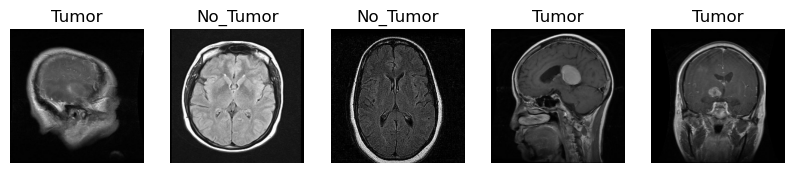

In [8]:
# Anzahl der Bilder, die angezeigt werden sollen
num_images = 5

# Hole eine kleine Stichprobe von Bildern und Labels
image_batch, label_batch = next(iter(train_ds))

# Anzeigen der Bilder und ihrer Klassen
plt.figure(figsize=(10, 10))

for i in range(num_images):
    ax = plt.subplot(1, num_images, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[label_batch[i].numpy()])
    plt.axis("off")

plt.show()


In [ ]:
# Modell erstellen
model = models.Sequential([
    # Erstes Convolutional Layer mit Max-Pooling
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normierung der Pixelwerte
    layers.Conv2D(32, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Zweites Convolutional Layer mit Max-Pooling
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Drittes Convolutional Layer mit Max-Pooling
    layers.Conv2D(128, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Flatten und Dense Layer
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(train_ds.class_names), activation='softmax')  # Anzahl der Klassen (Tumor/No_Tumor)
])

# Modell zusammenfassen
model.summary()

# EarlyStopping Callback definieren
early_stopping = EarlyStopping(monitor='val_loss',  # Überwachen des Validation Loss
                               patience=10,         # Geduld (wie viele Epochen ohne Verbesserung)
                               restore_best_weights=True)  # Bestes Modell wird zurückgegeben

# Modell kompilieren
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Modell trainieren mit EarlyStopping Callback
history = model.fit(
    train_ds,
    epochs=20,  # Anzahl der Epochen
    validation_data=test_ds,
    callbacks=[early_stopping], # Callback hinzufügen
    )

/opt/conda/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 106, 106, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 49, 49, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,166,402 (73.11 MB)

 Trainable params: 19,166,402 (73.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1734643507.749954  132555 service.cc:146] XLA service 0x7f5c880089f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734643507.750072  132555 service.cc:154]   StreamExecutor device (0): NVIDIA A16, Compute Capability 8.6
2024-12-19 21:25:08.039538: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-19 21:25:08.230717: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-12-19 21:25:08.555885: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
20

68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6917 - loss: 0.5734

2024-12-19 21:25:42.451849: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2239', 8 bytes spill stores, 8 bytes spill loads

2024-12-19 21:25:42.604908: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2239', 24 bytes spill stores, 24 bytes spill loads



69/69 ━━━━━━━━━━━━━━━━━━━━ 58s 483ms/step - accuracy: 0.6950 - loss: 0.5692 - val_accuracy: 0.8008 - val_loss: 0.4290
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9203 - loss: 0.2050 - val_accuracy: 0.8420 - val_loss: 0.3442
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9626 - loss: 0.1284 - val_accuracy: 0.8679 - val_loss: 0.3008
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9491 - loss: 0.1354 - val_accuracy: 0.8672 - val_loss: 0.2889
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9772 - loss: 0.0755 - val_accuracy: 0.8885 - val_loss: 0.2624
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9702 - loss: 0.0940 - val_accuracy: 0.8901 - val_loss: 0.2455
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9831 - loss: 0.0596 - val_accuracy: 0.9053 - val_loss: 0.2269
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9849 - loss: 0.0516 - val_accuracy: 0.928

In [ ]:
# Training und Validierung Genauigkeit plotten
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training und Validierung Verlust plotten
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Vorbereitung der Testdaten für Vorhersagen
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = tf.concat(test_images, axis=0)
test_labels = tf.concat(test_labels, axis=0)

# Vorhersagen machen
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# DataFrame mit wahren Labels und vorhergesagten Labels für Visualisierung
results_df = pd.DataFrame({
    'True Label': test_labels.numpy(),
    'Predicted Label': predicted_labels
})

# Visualisierung der Häufigkeit der Vorhersagen für jedes wahre Label
plt.figure(figsize=(16, 6))
for i in range(len(train_ds.class_names)):  # Wir haben 2 Klassen: 'Tumor' und 'No_Tumor'
    plt.subplot(1, 2, i + 1)  # 1 Reihe, 2 Spalten (da wir 2 Klassen haben)
    sns.histplot(results_df[results_df['True Label'] == i]['Predicted Label'], bins=np.arange(3) - 0.5, kde=False)
    plt.title(f'Vorhersagen für {train_ds.class_names[i]}')
    plt.xlabel('Vorausgesagte Klasse')
    plt.ylabel('Häufigkeit')
    plt.xticks([0, 1], labels=train_ds.class_names)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Wahre Labels und vorhergesagte Labels aus results_df extrahieren
true_labels = results_df['True Label']
predicted_labels = results_df['Predicted Label']

# Confusion Matrix berechnen
cm = confusion_matrix(true_labels, predicted_labels)

# Confusion Matrix visualisieren
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()